In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-consumption-dataset/est_hourly.paruqet
/kaggle/input/hourly-consumption-dataset/DOM_hourly.csv
/kaggle/input/hourly-consumption-dataset/EKPC_hourly.csv
/kaggle/input/hourly-consumption-dataset/DUQ_hourly.csv
/kaggle/input/hourly-consumption-dataset/DAYTON_hourly.csv
/kaggle/input/hourly-consumption-dataset/PJME_hourly.csv
/kaggle/input/hourly-consumption-dataset/PJM_Load_hourly.csv
/kaggle/input/hourly-consumption-dataset/NI_hourly.csv
/kaggle/input/hourly-consumption-dataset/FE_hourly.csv
/kaggle/input/hourly-consumption-dataset/COMED_hourly.csv
/kaggle/input/hourly-consumption-dataset/AEP_hourly.csv
/kaggle/input/hourly-consumption-dataset/pjm_hourly_est.csv
/kaggle/input/hourly-consumption-dataset/DEOK_hourly.csv
/kaggle/input/hourly-consumption-dataset/PJMW_hourly.csv


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [19]:
df = pd.read_csv('../input/hourly-consumption-dataset/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index) 


#Set Index, good for timeseries data


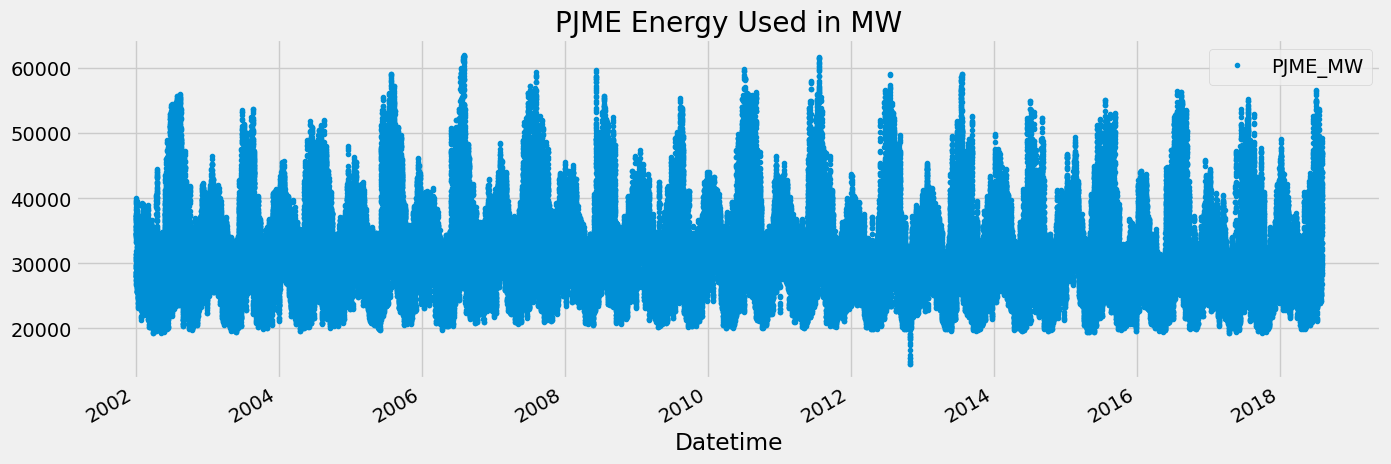

In [20]:
df.plot(style= '.', figsize=(15,5), color=color_pal[0], title = 'PJME Energy Used in MW')
plt.show()

#Explore data 

In [21]:
df.index

#Cast from object to DateTime

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [22]:
pd.to_datetime(df.index) 

#Cast from object to DateTime


DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

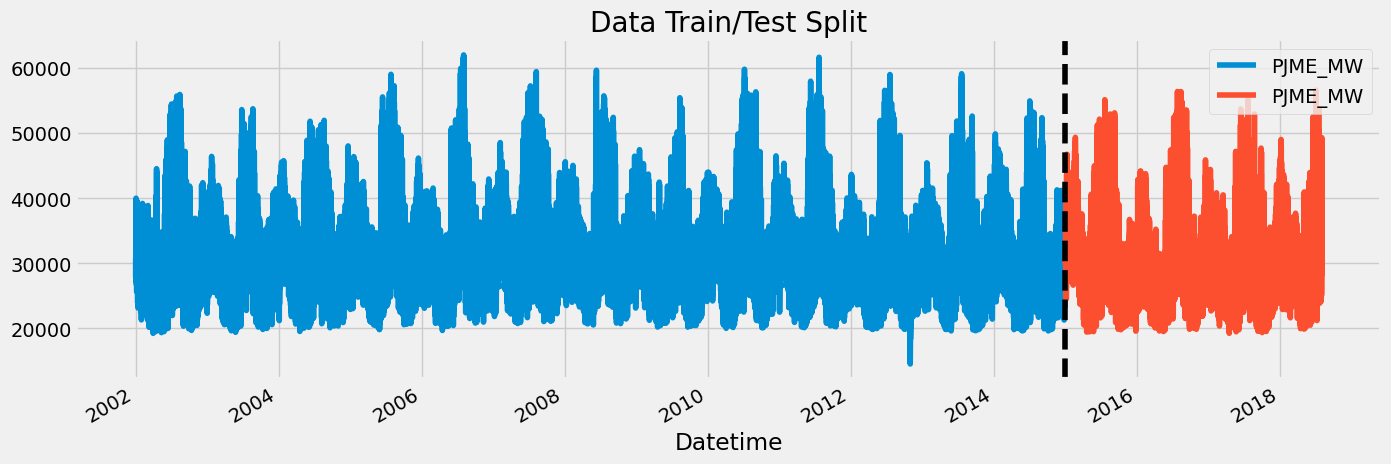

In [23]:
# Train / Test Split 

train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']


fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training', title = 'Data Train/Test Split')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black',ls= '--')
plt.show()


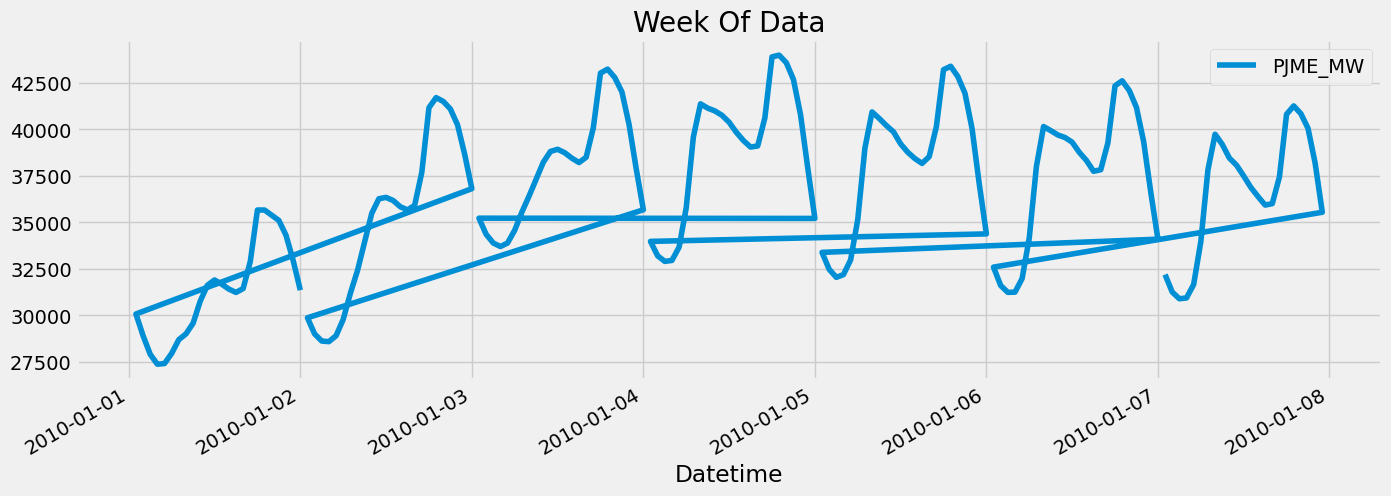

In [24]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [25]:
#feature creation 

def create_features(df):
    """
    Create time series features based on time series index.
    """
  
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
  
    return df



In [26]:
df = create_features(df)

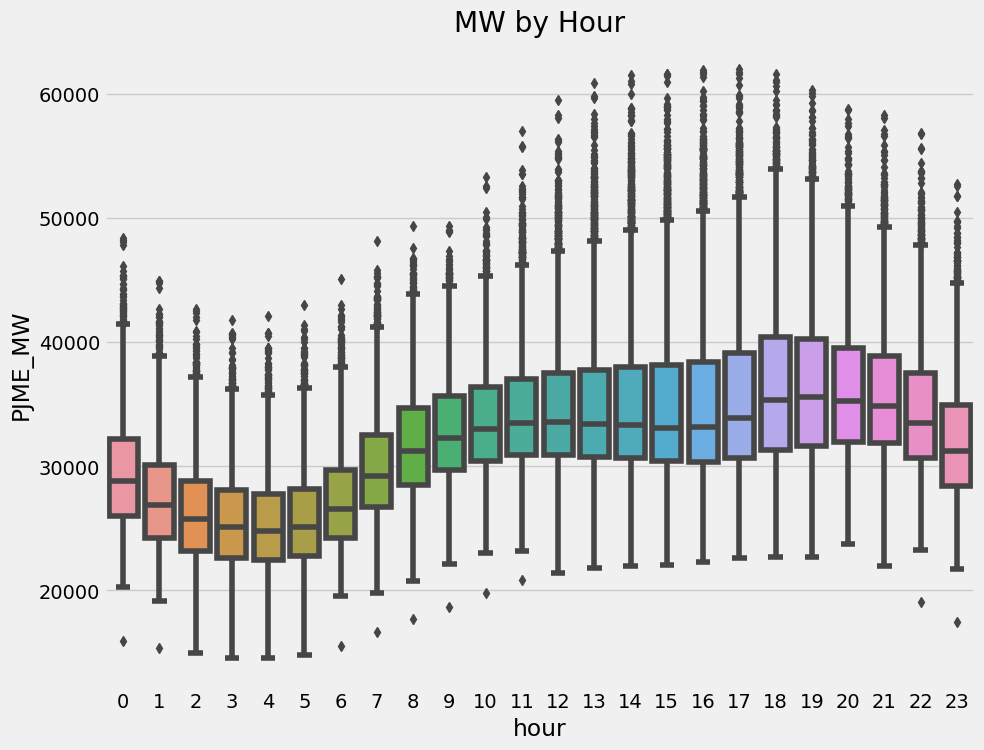

In [27]:
#Visualzie Features 

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

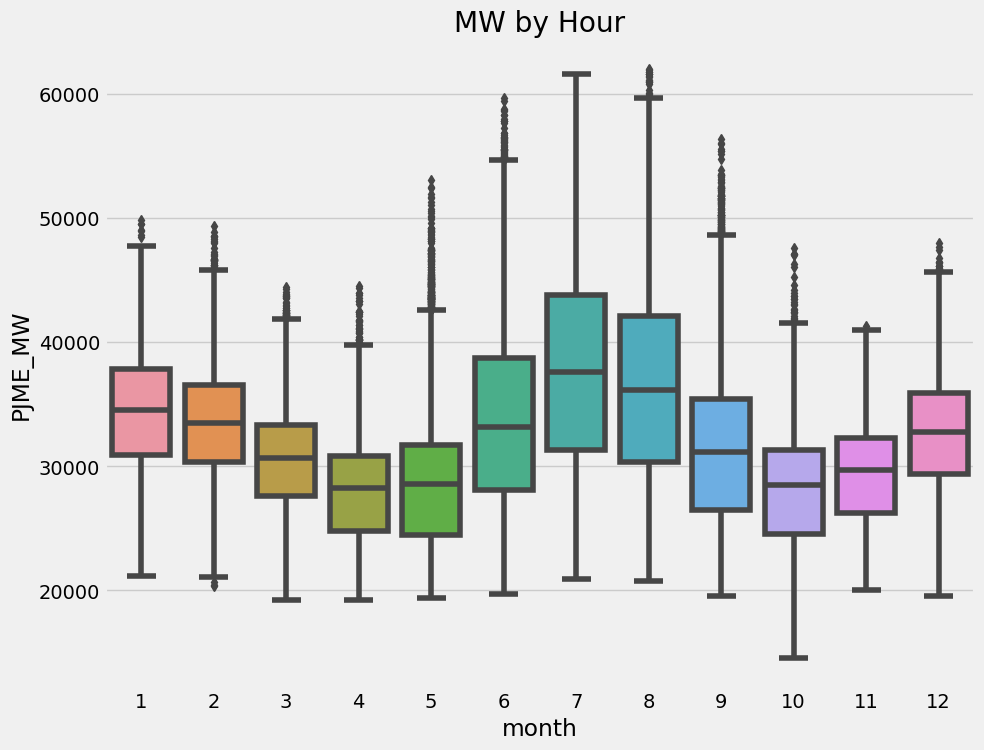

In [28]:
#Visualzie Features 

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

In [29]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

/tmp/ipykernel_31/858857324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_31/858857324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/tmp/ipykernel_31/858857324.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [41]:
#create our model 

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_round=50, learning_rate=0.01)
reg.fit(X_train, y_train,
       eval_set = [(X_train,y_train), (X_test,y_test)], 
        verbose= 100) 



[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:42:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.83677
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.99037
[500]	validation_0-rmse:2696.13844	validation_1-rmse:3782.63257
[600]	validation_0-rmse:2591.46362	validation_1-rmse:3824.27202
[700]	validation_0-rmse:2510.88990	validation_1-rmse:3855.66485
[800]	validation_0-rmse:2453.43132	validation_1-rmse:3893.10740
[900]	validation_0-rmse:2412.70587	validation_1-rmse:3931.40827
[999]	validation_0-rmse:2377.89351	validation_1-rmse:3958.39664


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [44]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index =reg.feature_names_in_,
             columns=['importance']) 

<Axes: title={'center': 'Feature Importance'}>

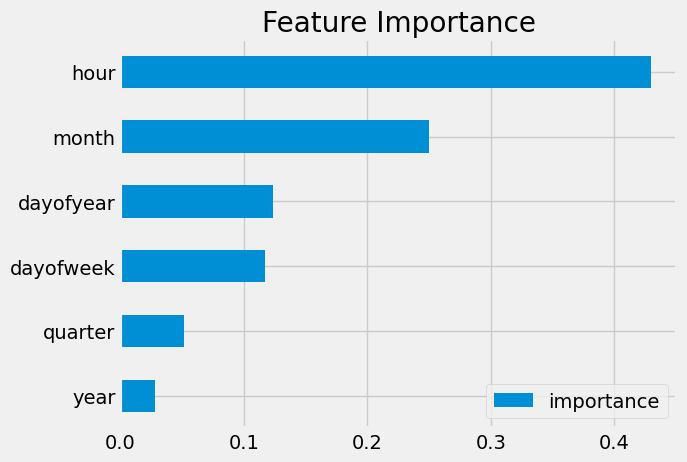

In [45]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

In [46]:
#Forecast on Test

reg.predict(X_test)

array([32304.03 , 29330.367, 28143.715, ..., 34774.51 , 33552.55 ,
       32133.19 ], dtype=float32)

In [49]:
test['prediction'] = reg.predict(X_test)


/tmp/ipykernel_31/3399550843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [52]:
df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,prediction_x,prediction_y
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,NaN,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,NaN,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,NaN,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,NaN,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,37417.218750,37417.218750
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,36929.527344,36929.527344
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,34774.511719,34774.511719


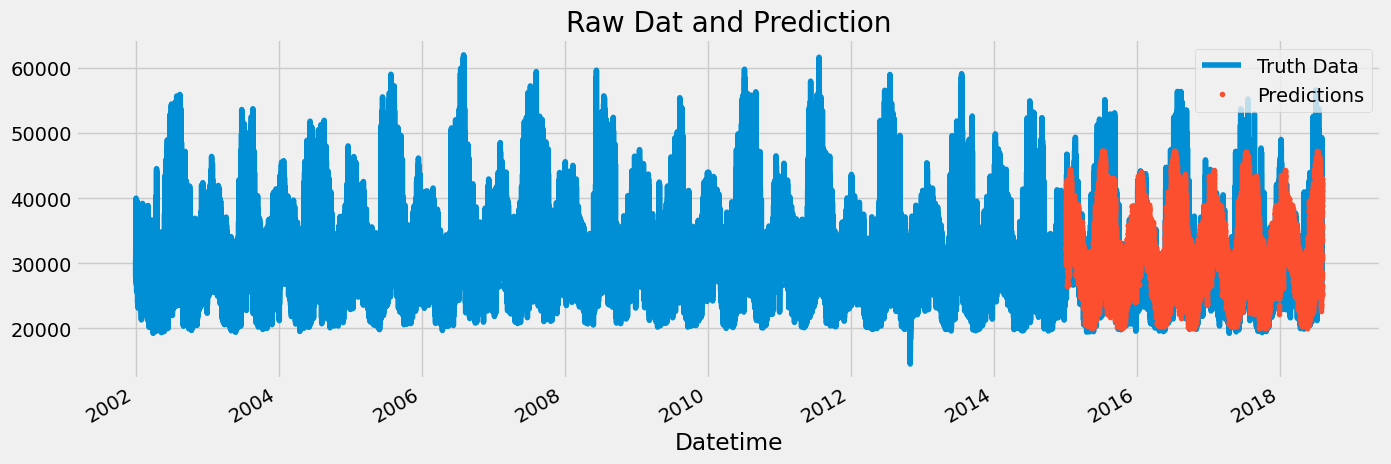

In [53]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

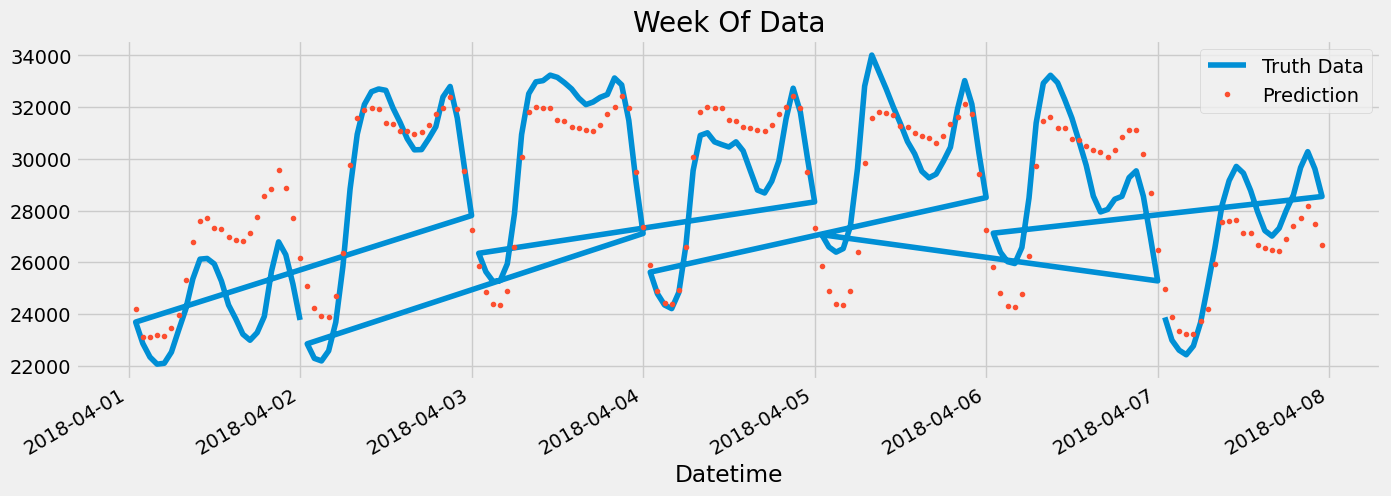

In [59]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize= (15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [60]:
#Score 

score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3958.40


In [61]:
#Calculate Error 

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    16512.169678
2016-08-14    16438.347412
2016-08-12    12419.644613
2016-09-10    11107.929525
2016-09-09    10801.659017
2016-08-15    10654.005046
2017-05-19    10601.772461
2016-08-11    10441.915527
2015-02-20    10415.485840
2017-01-25    10329.219564
Name: error, dtype: float64